In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_public.csv
/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_private.csv
/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/train.csv


In [2]:
# Importaciónde bibliotecas usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
# Cargamos los datasets
train = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/train.csv')
test_public = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_public.csv')
test_private = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_private.csv')

print("Primeras filas de train (5 filas):")
print(train.head())

print("\nTipos de datos de train:")
print(train.info())

Primeras filas de train (5 filas):
   CHD_OR_MI  SEX  AGE  HEALTH  PHYSICAL_HEALTH  MENTAL_HEALTH  \
0        1.0    1   34     1.0              1.0            2.0   
1        0.0    1   76     1.0              1.0            1.0   
2        1.0    2   69     1.0              1.0            1.0   
3        1.0    2   36     1.0              1.0            1.0   
4        1.0    2   21     1.0              1.0            2.0   

   PHYSICAL_ACTIVITIES  BLOOD_PRESSURE  HIGH_CHOLESTEROL  SKIN_CANCER  ...  \
0                  1.0             1.0               2.0          2.0  ...   
1                  2.0             2.0               1.0          1.0  ...   
2                  2.0             2.0               2.0          2.0  ...   
3                  1.0             1.0               2.0          2.0  ...   
4                  1.0             1.0               1.0          2.0  ...   

   SMOKE  TABACCO_PRODUCTS  E_CIGARETTES  HEAVY_DRINKERS  HIV  FRUITS  \
0    2.0               3.0

In [4]:
# Pre-procesamietno

# Valores faltantes de cada conjunto de datos
print("\nValores nulos de train:")
print(train.isnull().sum())
print("\nValores nulos de test_public:")
print(test_public.isnull().sum())
print("\nValores nulos de test_private:")
print(test_private.isnull().sum())


# Función para pre-procesamiento
def preprocesamiento(df, eliminar_id=True):
    if eliminar_id:
        col_irrelevante = ["ID"]
        df = df.drop(columns=col_irrelevante, errors="ignore")
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df


# Pre-preocesamiento para cada conjunto de datos
train = preprocesamiento(train)
test_public = preprocesamiento(test_public, eliminar_id=False)
test_private = preprocesamiento(test_private, eliminar_id=False)

# Valores nulos después del pre-procesamiento
print("\nValores nulos en train.csv después del preprocesamiento:")
print(train.isnull().sum())
print("\nValores nulos en test_public.csv después del preprocesamiento:")
print(test_public.isnull().sum())
print("\nValores nulos en test_private.csv después del preprocesamiento:")
print(test_private.isnull().sum())

# Verificar las primeras filas de cada conjunto de datos
print("Primeras filas de train (5 filas) despues de pre-procesamiento:")
print(train.head())

print("Primeras filas de test_public (5 filas) despues de pre-procesamiento:")
print(test_public.head())

print("Primeras filas de test_private (5 filas) despues de pre-procesamiento:")
print(test_private.head())



Valores nulos de train:
CHD_OR_MI                  0
SEX                        0
AGE                        0
HEALTH                   838
PHYSICAL_HEALTH         7306
MENTAL_HEALTH           6034
PHYSICAL_ACTIVITIES      653
BLOOD_PRESSURE          1307
HIGH_CHOLESTEROL       50191
SKIN_CANCER              867
CANCER                   792
BRONCHITIS              1313
DEPRESSIVE_DISORDER     1686
KIDNEY_DISEASE          1131
DIABETES                 530
ARTHRITIS               1954
BMI                    36960
DIFFICULTY_WALKING     15604
SMOKE                  19263
TABACCO_PRODUCTS       18033
E_CIGARETTES           18884
HEAVY_DRINKERS         27583
HIV                    40794
FRUITS                 40254
VEGETABLES             47387
FRIED_POTATOES         35302
ETHNICITY                  0
ID                         0
dtype: int64

Valores nulos de test_public:
CHD_OR_MI                 0
SEX                       0
AGE                       0
HEALTH                  112
PHYSICA

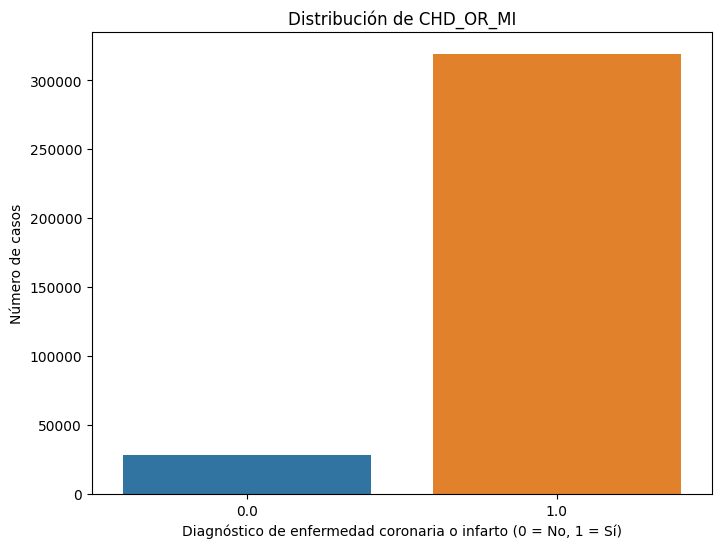


Clases de la variable objetivo
CHD_OR_MI
1.0    318988
0.0     28258
Name: count, dtype: int64

Mapa de calor de la matriz de correlación


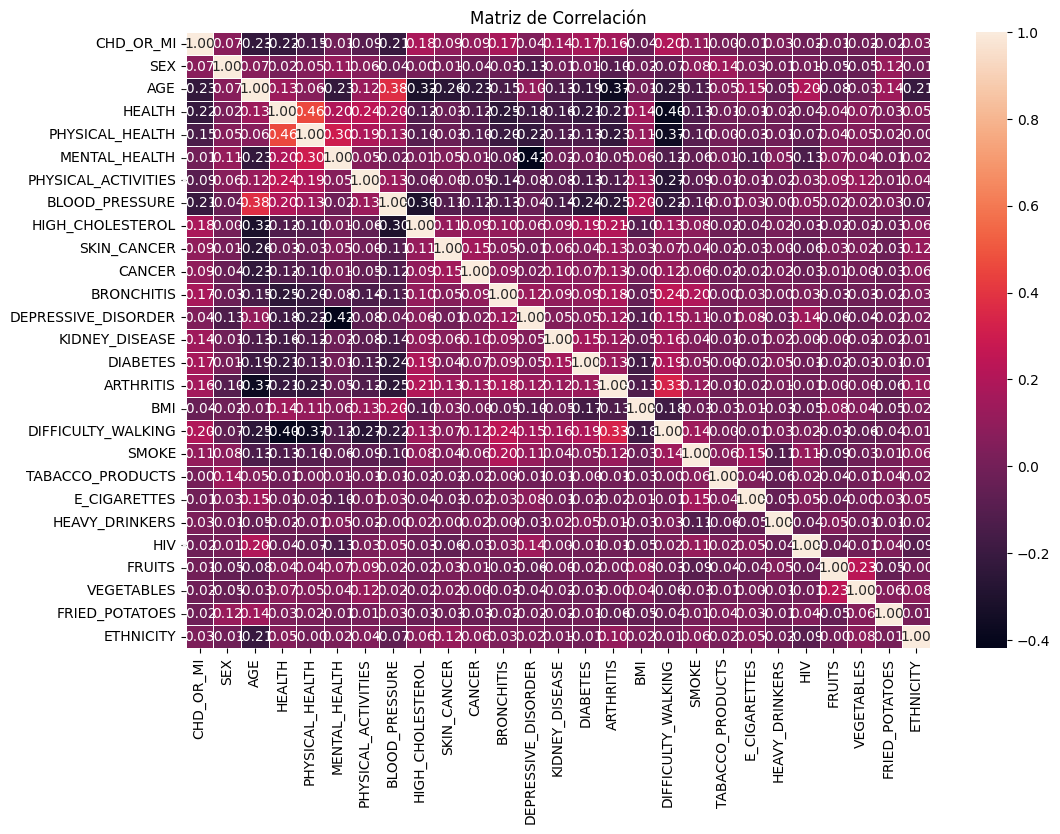

In [5]:
# Distribucion de datos (analisis para balanceo de clases)

#Distribución de la variable objetivo (CHD_OR_MI)
plt.figure(figsize=(8, 6))
sns.countplot(x='CHD_OR_MI', data=train)
plt.title('Distribución de CHD_OR_MI')
plt.xlabel('Diagnóstico de enfermedad coronaria o infarto (0 = No, 1 = Sí)')
plt.ylabel('Número de casos')
plt.show()

# Clases de la variable objetivo (CHD_OR_MI)'
print("\nClases de la variable objetivo")
print(train['CHD_OR_MI'].value_counts())

# Matriz de correlación de las características numéricas
col_num = train.select_dtypes(include=['float64', 'int64']).columns
matriz_corre = train[col_num].corr()

# Mapa de calor de la matriz de correlación
print("\nMapa de calor de la matriz de correlación")
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_corre, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp

Distribución de clases de CHD_OR_MI: Counter({1.0: 318988, 0.0: 28258})
Distribución de clases después de SMOTE: Counter({1.0: 318988, 0.0: 318988})


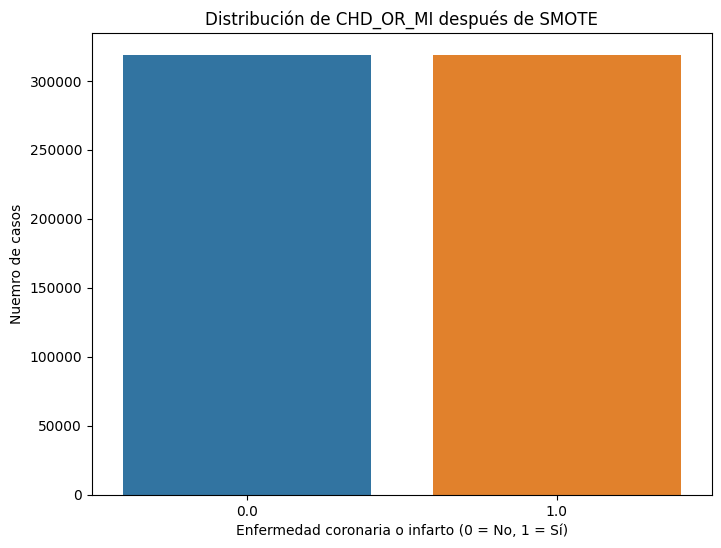


Primeras filas de train:
   CHD_OR_MI  SEX  AGE  HEALTH  PHYSICAL_HEALTH  MENTAL_HEALTH  \
0        1.0    1   34     1.0              1.0            2.0   
1        0.0    1   76     1.0              1.0            1.0   
2        1.0    2   69     1.0              1.0            1.0   
3        1.0    2   36     1.0              1.0            1.0   
4        1.0    2   21     1.0              1.0            2.0   

   PHYSICAL_ACTIVITIES  BLOOD_PRESSURE  HIGH_CHOLESTEROL  SKIN_CANCER  ...  \
0                  1.0             1.0               2.0          2.0  ...   
1                  2.0             2.0               1.0          1.0  ...   
2                  2.0             2.0               2.0          2.0  ...   
3                  1.0             1.0               2.0          2.0  ...   
4                  1.0             1.0               1.0          2.0  ...   

   DIFFICULTY_WALKING  SMOKE  TABACCO_PRODUCTS  E_CIGARETTES  HEAVY_DRINKERS  \
0                 2.0    2.0

In [6]:
# Balanceo de clases usando SMOTE

# Definir la variable objetivo (CHD_OR_MI)
X = train.drop(columns=['CHD_OR_MI'])
y = train['CHD_OR_MI']

# Distribución original de las clases de CHD_OR_MI
print(f'Distribución de clases de CHD_OR_MI: {Counter(y)}')

# Usamos SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Mostrar la nueva distribución de clases después de SMOTE
print(f'Distribución de clases después de SMOTE: {Counter(y_res)}')

# Crear un nuevo DataFrame con las características balanceadas
train_res = pd.DataFrame(X_res, columns=X.columns)
train_res['CHD_OR_MI'] = y_res

# Figura de nueva distribución de clases de CHD_OR_MI
plt.figure(figsize=(8, 6))
sns.countplot(x='CHD_OR_MI', data=train_res)
plt.title('Distribución de CHD_OR_MI después de SMOTE')
plt.xlabel('Enfermedad coronaria o infarto (0 = No, 1 = Sí)')
plt.ylabel('Nuemro de casos')
plt.show()

# Verificar las primeras filas de cada conjunto de datos para asegurarse de que el preprocesamiento se haya realizado correctamente
print("\nPrimeras filas de train:")
print(train.head())

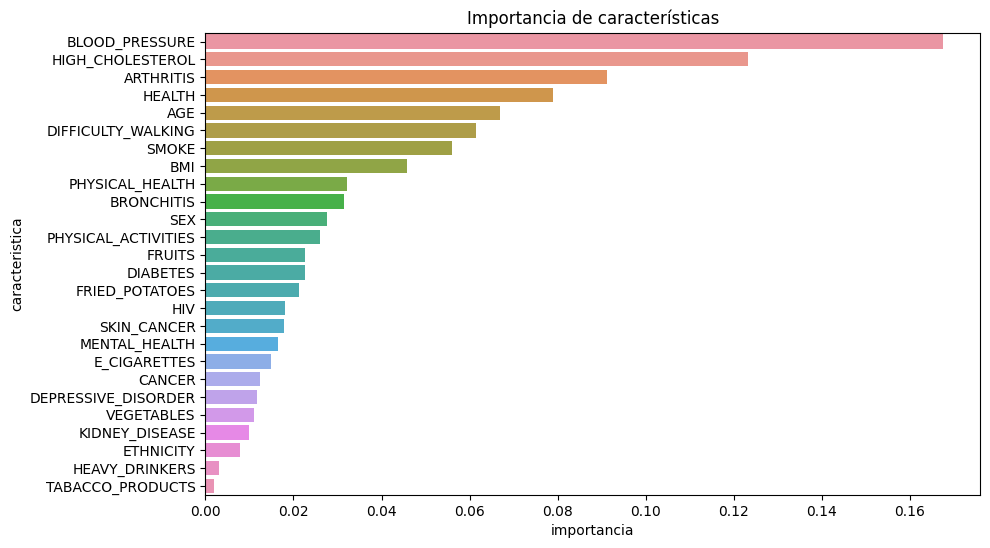

         caracteristica  importancia
6        BLOOD_PRESSURE     0.167614
7      HIGH_CHOLESTEROL     0.123107
14            ARTHRITIS     0.091142
2                HEALTH     0.079045
1                   AGE     0.067006
16   DIFFICULTY_WALKING     0.061338
17                SMOKE     0.055949
15                  BMI     0.045766
3       PHYSICAL_HEALTH     0.032159
10           BRONCHITIS     0.031524
0                   SEX     0.027596
5   PHYSICAL_ACTIVITIES     0.026065
22               FRUITS     0.022599
13             DIABETES     0.022578
24       FRIED_POTATOES     0.021145
21                  HIV     0.018140
8           SKIN_CANCER     0.017948
4         MENTAL_HEALTH     0.016474
19         E_CIGARETTES     0.014973
9                CANCER     0.012471
11  DEPRESSIVE_DISORDER     0.011650
23           VEGETABLES     0.011003
12       KIDNEY_DISEASE     0.009883
25            ETHNICITY     0.007960
20       HEAVY_DRINKERS     0.002976
18     TABACCO_PRODUCTS     0.001888


In [7]:
# Seleccion de caracteristicas

# Definimos variable objetivo (CHD_OR_MI)
X = train_res.drop(columns=['CHD_OR_MI'])
y = train_res['CHD_OR_MI']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de RandomForest para obtener la importancia de las características
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# importancia de características
importancia = model.feature_importances_

# DataFrame para características e importancias
importancia_carac = pd.DataFrame({
    'caracteristica': X.columns,
    'importancia': importancia
})

# Ver características importantes descendentemente
importancia_carac = importancia_carac.sort_values(by='importancia', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importancia', y='caracteristica', data=importancia_carac)
plt.title('Importancia de características')
plt.show()

# Importancia de caracteriticas
print("\Importancia de caracteriticas:")
print(importancia_carac)


Características seleccionadas: Index(['SEX', 'AGE', 'HEALTH', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH',
       'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL',
       'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'DEPRESSIVE_DISORDER',
       'KIDNEY_DISEASE', 'DIABETES', 'ARTHRITIS', 'BMI', 'DIFFICULTY_WALKING',
       'SMOKE', 'TABACCO_PRODUCTS', 'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV',
       'FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 'ETHNICITY'],
      dtype='object')
        SEX  AGE  HEALTH  PHYSICAL_HEALTH  MENTAL_HEALTH  PHYSICAL_ACTIVITIES  \
130659    1   43     1.0         1.000000            1.0                  1.0   
190997    2   28     1.0         1.000000            1.0                  1.0   
483204    1   47     2.0         3.000000            3.0                  2.0   
579374    1   61     1.0         1.651188            1.0                  1.0   
4822      1   62     1.0         1.000000            1.0                  1.0   

        BLOOD_PRESSURE  HIGH_CHOLESTE

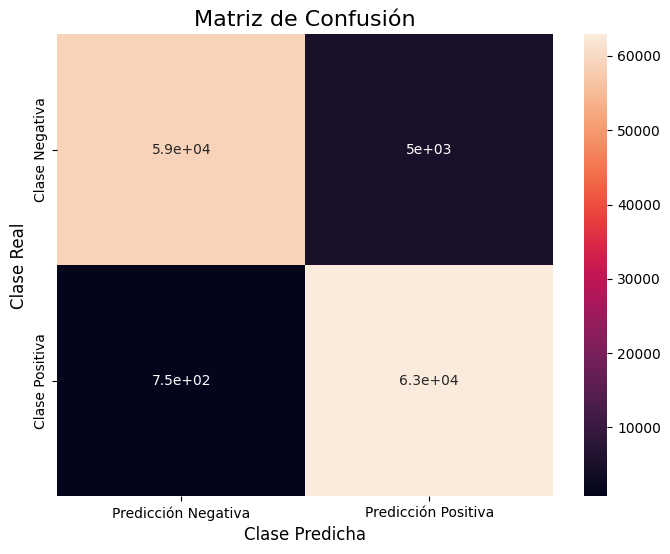

F1 Score: 0.9559800033429061


In [10]:
# Entrenamiento de modelo (RandomForest) con caracteristicas seleccioandas

# Seleccionar las características más importantes usando un umbral
sfm = SelectFromModel(model, threshold=0.001)
sfm.fit(X_train, y_train)

# Obtener las características seleccionadas
caracteristicas_select = X.columns[sfm.get_support()]
print(f'Características seleccionadas: {caracteristicas_select}')

# Filtramios DataFrame con solo las características seleccionadas
X_train_select = X_train[caracteristicas_select]
X_test_select = X_test[caracteristicas_select]

# Verificar las primeras filas de las características seleccionadas en el conjunto de entrenamiento
print(X_train_select.head())

# Entrenar nuevamente el modelo con las características seleccionadas
model.fit(X_train_select, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred = model.predict(X_test_select)

# Convertir la matriz de confusión en un DataFrame para mejor visualización
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Clase Negativa', 'Clase Positiva'], columns=['Predicción Negativa', 'Predicción Positiva'])

# mMtriz de confusión en texti
print("\nMatriz de confusión:")
print(cm_df)

# Mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True)
plt.title('Matriz de Confusión', fontsize=16)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.show()

# Calcular el F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

In [9]:
# Evaluamos el modelo con test_public
X_test_public = test_public[caracteristicas_select]
y_test_public = test_public['CHD_OR_MI']
y_test_public_pred = model.predict(X_test_public)

# F1 Score en test_public
f1_test_public = f1_score(y_test_public, y_test_public_pred)
print(f'F1-Score para test_public: {f1_test_public}')

# Predicción en test_private
X_test_private = test_private[caracteristicas_select]
y_test_private_pred = model.predict(X_test_private)

# Creamos resultados (test_public y test_private)
predicciones_public = pd.DataFrame({
    'ID': test_public['ID'],
    'CHD_OR_MI': y_test_public_pred
})

predicciones_private = pd.DataFrame({
    'ID': test_private['ID'],
    'CHD_OR_MI': y_test_private_pred
})

# Juntamos las predicciones de test_public y test_private
results = pd.concat([predicciones_public, predicciones_private], axis=0)

# Guardar las predicciones en un archivo (csv)
results.to_csv('resultados.csv', index=False)
results.to_csv('submission.csv', index=False)

print("Se creo archivo de resultados :D")

F1-Score para test_public: 0.956002133229904
Se creo archivo de resultados :D
